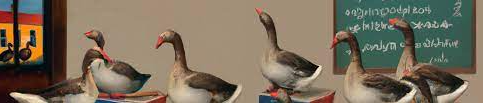

# Introduction ⚡

This notebooks contains my solution for the "**Playground Series - Season 3, Episode 6**".

For people who dont know, this competition charachteristic was the extremely noisy data and outliers.
You can find a lot of interesting topics in discussion [thread](https://www.kaggle.com/competitions/playground-series-s3e6/discussion)

Due to the above reason the Public Leaderboard was missleading, a lot of simple approaches without Cross Validation had the luck to be in the top places and also bias other competitors to follow their approach.I have to admit that I was one of them in the beggining of the competition because I was thinking that I'm in the wrong direction.

Finally, **this solution took the 5th place🎉** due to 98% Cross Validation trust, if I had 100% trust and I would choose the best solution based on the CV and not the second based on my instinct I would take the 3rd place.. but this is Kaggle!

This is my first attempt in open competition and the lesson is more important than the position!

## Things that worked 🔥
* **Remove outliers** - Run IQR for each column and remove the rows with the outliers (just 20 records). The outlier removal was not so important for the final model performance but it was important for the CV, because the RMSE metric is very sensitive to outliers and can lead to missleading results.
* **Piece-Wise model** (I like the terminology from @PRASAD)- Split the models based on different periods (based on made column). The best score was by spliting the data in 4 periods.
* **Multi-StratifiedKFold** - Run StratifiedKFold many times with different SEEDS. This give me the confidence to have good statistics about model performance (MeanScore +/- SD). The second key point is the selection of the "Statified" CV. Due to "Piece-Wise model" approach I had to stratify the data based on the "made" column in order to have consistent results.
* **Ensemble Model** - From CV I observed that different models (e.g Random Forest, XGBoost) had case that were good and others are not, so an ensemble model created a more stable solution.
* **Low number of estimators** - I used few estimators because with more estimators the models were overfitting in data noise
* **Use all the features (except CityCode)** - The most dominant feature was the size of the house (squareMeters column). It was the only feature with significan correlation (~ =53%) with the target and feature importance (~ =99%), all the others were look to be noise. But the CV show me that the other features were play some role and maybe in edge cases were helping the model to take the right decision, so I keep them!
* **No extra features** - After searching for artificial features that would probably help the model performance, I couldn;t find features which improve the CV score, so I didn't use any extra features.
* **Include original data** - The original data were looked different (based on Adversarial validation) but If we keep only the squareMeters columns the dataset were approximately the same, so I tried to include them in the training dataset and the results were better.

In [ ]:
import re

import numpy as np 
import pandas as pd

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, VotingRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('plotting.backend', 'plotly')
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', -1)

### Notebook Config

In [ ]:
RUN_EVALUATION   = True  # Runs or not the evaluation scripts
CREAT_SUBMISSION = True   # Creates or not the submission.csv file

## Load Data

In [ ]:
original_df = pd.read_csv('/kaggle/input/paris-housing-price-prediction/ParisHousing.csv')
train_df = pd.read_csv('/kaggle/input/playground-series-s3e6/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s3e6/test.csv')

# Remove made outliers
train_df = train_df[train_df['made']<=2021]

## Preprocessing

In [ ]:
def model_predict(train_df, original_df, test_df, verbose=False):
    train_df = train_df.copy()
    original_df = original_df.copy()
    test_df = test_df.copy()
    
    # -----------------------
    # CLEANING
    # -----------------------
    outlier_ids = [15334, 5659, 2113, 3608, 19124, 19748, 21400, 2107,
                   3995, 15068, 18926, 3828, 4909, 12858, 13633, 13642,
                   17168, 19994, 14878, 17629]

    train_df[~train_df['id'].isin(outlier_ids)]
    
    # -----------------------
    # PRE-PROCESSING
    # -----------------------
    train_df = train_df.drop(columns=['id'])
    
    train_df['original'] = 0
    original_df['original'] = 1
    test_df['original'] = 0
    
    train_df = pd.concat([train_df, original_df])
    
    # Create yearly stats
    made = train_df.groupby(['made','original'], as_index=False)\
                   .agg(**{'count': pd.NamedAgg(column='made', aggfunc='count')})

    # Merge with 'made' dataframe
    train_df = pd.merge(train_df, made, on=['made','original'], how='left')
    test_df = pd.merge(test_df, made, on=['made','original'], how='left')

    # -----------------------
    # ENSEMBLE MODEL
    # -----------------------
    rf = RandomForestRegressor(random_state=0)
    gb = GradientBoostingRegressor(random_state=0)
    xgb = XGBRegressor(n_estimators=300,
                       gamma=0.1,
                       random_state=0)
    cb = CatBoostRegressor(l2_leaf_reg=1,
                           depth=6,
                           verbose=False,
                           random_state=0)
    estimators = [('rf', rf),
                  ('gb', gb),
                  ('xgb', xgb),
                  ('cb', cb)
    ]
    model = VotingRegressor(estimators=estimators)
    
    # -----------------------
    # RANGES SPLIT
    # -----------------------
    ranges = [
        lambda df: df['made']<=2005,
        lambda df: (df['made']>2005) & (df['made']<=2007),
        lambda df: (df['made']>2007) & (df['made']<=2015),
        lambda df: df['made']>2015
    ]
    
    # -----------------------
    # PREDICTION
    # -----------------------
    for i, range_ in enumerate(ranges):
        train_ = train_df[range_(train_df)]
        test_ = test_df[range_(test_df)]
        model.fit(train_.drop(columns=['price']), train_['price'])
        model_scores = []
        # GET ESTIMATORS SCORES
        if verbose:
            print(f' - Range: {i+1}/{len(ranges)}')
            for estimator in model.estimators_:
                score = mean_squared_error(estimator.predict(test_[train_.drop(columns=['price']).columns]), test_['price'], squared=False)
                model_scores.append((score))
                best_estimator = estimators[np.argmin(model_scores)][0]
            print(f'    - Estimators Score: {model_scores} | BEST: {best_estimator}')
        pred = model.predict(test_[train_.drop(columns=['price']).columns])
        test_df.loc[range_(test_df), 'price'] = pred.clip(0)
    return test_df['price']

## Model Evaluation 💪

### PART-1: Train-Test Split (80/20) [Fast Evaluation]

In [ ]:
if RUN_EVALUATION:
    # NOTE:  Remove 2002 because has only 1 record and it creates problem with the CV
    train_df_ = train_df[~train_df['made'].isin([2002])]

    X_train, X_val = train_test_split(train_df_,
                                      test_size=0.20,
                                      shuffle=True,
                                      random_state=0,
                                      stratify=train_df_['made']
    )
    prediction = model_predict(X_train, original_df, X_val)
    score = mean_squared_error(prediction, X_val["price"], squared=False)
    print('======= TRAIN-TEST SPLIT SCORE ==========')
    print(f'* RMSE:{score}')

### PART-2: Multi CrossValidation [Slow Evaluation]

In [ ]:
if RUN_EVALUATION:
    # Cross Validation Config
    N_SPLITS = 5
    N_RUNS = 3

    # NOTE:  Remove 2002 because has only 1 record and it creates problem with the CV
    train_df_ = train_df[~train_df['made'].isin([2002])]

    cv_results = []
    for run_id in range(1, N_RUNS+1):
        print('-----------------------------')
        print(f'* Run ID: {run_id}/{N_RUNS}')
        print('-----------------------------')
        skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=run_id)
        for i, (train_index, test_index) in enumerate(skf.split(train_df_, train_df_['made'])):
            X_train = train_df_.iloc[train_index]
            X_val = train_df_.iloc[test_index]

            test_prediction = model_predict(X_train, original_df, X_val)
            test_score = mean_squared_error(test_prediction, X_val["price"], squared=False)

            cv_results.append(test_score)
            mean_cv_scores = np.mean(cv_results)
            std_cv_scores = np.std(cv_results)

            print(f' * Iteration {i+1}/{N_SPLITS} | TEST SCORE: {test_score}')


    print('=========================')
    print('RESULTS')
    print('=========================')
    print("Cross-validation results ({}-fold):".format(N_SPLITS))
    print("Average Score = {:.2f} +/- {:.2f}".format(mean_cv_scores, std_cv_scores))

## Submission 🔥

In [ ]:
if CREAT_SUBMISSION:
    submit_df = pd.DataFrame({'id': test_df['id'], 'price': model_predict(train_df, original_df, test_df)})
    submit_df.to_csv('submission.csv', index=False)
    
    submit_df

# 🙌🤘 Hope for the best!